# Loan Approval Prediction - 3.3 assignment

1. Data loading & quick exploration
2. Preprocessing (missing values, categorical encoding, scaling)
3. Feature selection
4. Model training (**Logistic Regression** & **KNN**)
5. Model evaluation (**Accuracy, Precision, Recall, F1, ROC AUC**) and **ROC curves**
6. Inspect selected features


## 0) Setup & Data Loading

Import the libraries we need and load the dataset from a URL with a local fallback.  
Preview the data to understand column names and basic structure.


In [21]:
# Core
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt

# ML & Tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, RocCurveDisplay
)

# Display helper
from IPython.display import display

# ---- Load dataset (URL with local fallback) ----
loan_url = 'https://raw.githubusercontent.com/prasertcbs/basic-dataset/refs/heads/master/Loan-Approval-Prediction.csv'
local_path = 'Loan-Approval-Prediction.csv'

try:
    loan_data = pd.read_csv(loan_url)
except Exception:
    loan_data = pd.read_csv(local_path)

print('Shape:', loan_data.shape)
display(loan_data.head(10))


Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


## 1) Quick Exploration (EDA)

Check columns, missing values, and the distribution of the **target** (`Loan_Status`).  
This helps us plan preprocessing (imputation, encoding) and confirms the target values.


In [4]:
print('\nColumns:', list(loan_data.columns))

print('\nMissing values per column:')
display(loan_data.isna().sum().to_frame('missing'))

if 'Loan_Status' not in loan_data.columns:
    raise ValueError("Expected target column 'Loan_Status' not found.")

print('\nTarget distribution (raw):')
display(loan_data['Loan_Status'].value_counts())



Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

Missing values per column:


,missing
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14



Target distribution (raw):


Loan_Status
Y    422
N    192
Name: count, dtype: int64

## 2) Prepare Features & Target

- Copy the dataframe and convert the **target** `Loan_Status` to binary (1 = approved, 0 = not approved).  
- Separate **features (X)** and **target (y)** and identify **categorical** vs **numerical** columns.


In [5]:
df = loan_data.copy()

# Convert target to 0/1 if it's 'Y'/'N'
if df['Loan_Status'].dtype == object:
    df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0}).astype(int)

y = df['Loan_Status']
X = df.drop(columns=['Loan_Status'])

cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]

print('Categorical columns:', cat_cols)
print('Numerical columns :', num_cols)


Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
Numerical columns : ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


## 3) Preprocessing (Impute → Encode/Scale)

**Why this setup?**
- **Categorical**: impute missing values with most frequent, then **One-Hot Encode**.  
- **Numerical**: impute missing with **median**, then **Standardize** (0 mean, unit variance).

This is a good default that works well with many models (LogReg, KNN, SVM, NN).


In [6]:
# OneHotEncoder API differs by sklearn version; handle both
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('ohe', ohe)
        ]), cat_cols),
        ('num', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), num_cols)
    ]
)

print('Preprocessing ready.')

Preprocessing ready.


## 4) Train/Test Split

Hold out a test set to evaluate how well the model generalizes to **unseen** data.  
Use `stratify=y` to preserve the class balance.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print('Train shape:', X_train.shape, '| Test shape:', X_test.shape)

Train shape: (491, 12) | Test shape: (123, 12)


## 5) Feature Selection (Model-Based, L1‑Logistic Regression)

Use **L1‑penalized Logistic Regression** inside `SelectFromModel`.  
L1 tends to set some coefficients to **exactly zero**, allowing us to **keep only informative features**.

- This runs **after** preprocessing in the pipeline.
- `threshold='median'` keeps about half the features (adjust if needed).


In [8]:
fs_selector = SelectFromModel(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, class_weight='balanced'),
    threshold='median'
)
print('Feature selector ready.')

Feature selector ready.


## 6) Build Two Model Pipelines

Create two pipelines that include **preprocessing → feature selection → model**:

- **Logistic Regression** (good baseline classifier, with `class_weight='balanced'` to help with class imbalance)
- **K‑Nearest Neighbors (KNN)** with `n_neighbors=7` (can tune this later)


In [9]:
logreg_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('select', fs_selector),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

knn_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('select', fs_selector),
    ('model', KNeighborsClassifier(n_neighbors=7))
])

print('Pipelines ready.')

Pipelines ready.


## 7) Train the Models

Fit both pipelines on the training data.


In [10]:
logreg_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
print('Models trained.')

Models trained.


## 8) Evaluate the Models (Accuracy, Precision, Recall, F1, ROC AUC)

Use a helper function to compute and print common classification metrics and return probabilities for **ROC AUC** and **ROC curves**.


In [11]:
def evaluate_classifier(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    # Probability scores (for ROC AUC). Try predict_proba; fallback if needed.
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        scores = model.decision_function(X_test)
        smin, smax = scores.min(), scores.max()
        y_proba = (scores - smin) / (smax - smin + 1e-9)  # min-max to [0,1]
    else:
        y_proba = y_pred.astype(float)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC AUC  : {auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))

    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC_AUC': auc}, y_proba

res1, proba1 = evaluate_classifier('Logistic Regression', logreg_clf, X_test, y_test)
res2, proba2 = evaluate_classifier('KNN (k=7)', knn_clf, X_test, y_test)

results_df = pd.DataFrame([res1, res2]).sort_values('ROC_AUC', ascending=False)
display(results_df)


=== Logistic Regression ===
Accuracy : 0.846
Precision: 0.859
Recall   : 0.929
F1-score : 0.893
ROC AUC  : 0.855

Classification Report:
              precision    recall  f1-score   support

           0      0.806     0.658     0.725        38
           1      0.859     0.929     0.893        85

    accuracy                          0.846       123
   macro avg      0.833     0.794     0.809       123
weighted avg      0.843     0.846     0.841       123


=== KNN (k=7) ===
Accuracy : 0.846
Precision: 0.830
Recall   : 0.976
F1-score : 0.897
ROC AUC  : 0.840

Classification Report:
              precision    recall  f1-score   support

           0      0.913     0.553     0.689        38
           1      0.830     0.976     0.897        85

    accuracy                          0.846       123
   macro avg      0.872     0.765     0.793       123
weighted avg      0.856     0.846     0.833       123



,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.845528,0.858696,0.929412,0.892655,0.855418
1,KNN (k=7),0.845528,0.830000,0.976471,0.897297,0.840402


## 9) Plot ROC Curves

Plot ROC curves for both models on the **same chart**.  
Higher curves (and higher **AUC**) indicate better ranking performance.


<Figure size 640x480 with 0 Axes>

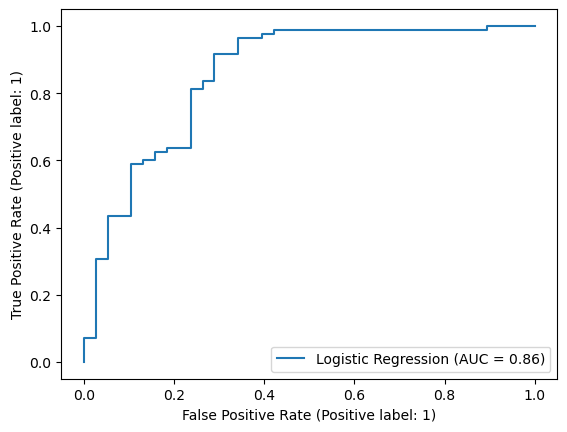

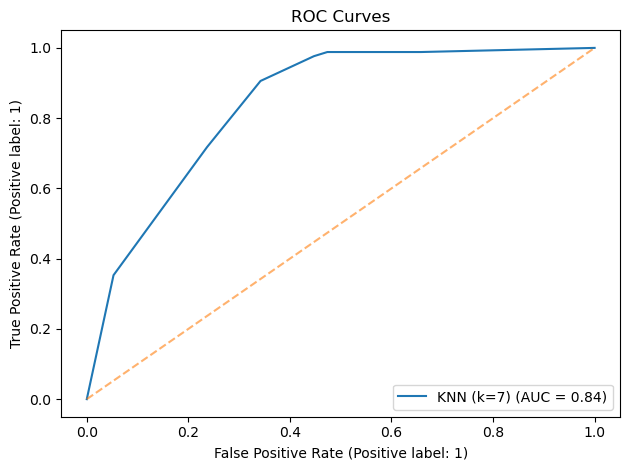

In [12]:
plt.figure()
RocCurveDisplay.from_predictions(y_test, proba1, name='Logistic Regression')
RocCurveDisplay.from_predictions(y_test, proba2, name='KNN (k=7)')
plt.plot([0,1], [0,1], '--', alpha=0.6)
plt.title('ROC Curves')
plt.tight_layout()
plt.show()

## 10) Which Features Were Selected?

Extract the feature names after preprocessing and show those **kept** by the L1‑based selector.


In [13]:
from copy import deepcopy

def get_feature_names(preprocess, cat_cols, num_cols):
    # 1) OneHotEncoded categorical names
    cat_ohe = preprocess.named_transformers_['cat'].named_steps['ohe']
    cat_names = list(cat_ohe.get_feature_names_out(cat_cols))
    # 2) Numeric names (scaler doesn't change names)
    num_names = list(num_cols)
    return cat_names + num_names

# Fit a copy of preprocess to get the full post-encoding feature list
prep_only = deepcopy(preprocess)
prep_only.fit(X_train, y_train)
all_feature_names = get_feature_names(prep_only, cat_cols, num_cols)

# Mask from the selector used inside the LogReg pipeline
selector = logreg_clf.named_steps['select']
mask = selector.get_support()

selected_features = [n for n, keep in zip(all_feature_names, mask) if keep]
print('Number of features after selection:', len(selected_features))
print('\nSelected features:')
for f in selected_features:
    print('-', f)

Number of features after selection: 511

Selected features:
- Loan_ID_LP001002
- Loan_ID_LP001003
- Loan_ID_LP001006
- Loan_ID_LP001008
- Loan_ID_LP001011
- Loan_ID_LP001013
- Loan_ID_LP001018
- Loan_ID_LP001020
- Loan_ID_LP001024
- Loan_ID_LP001028
- Loan_ID_LP001029
- Loan_ID_LP001030
- Loan_ID_LP001032
- Loan_ID_LP001034
- Loan_ID_LP001036
- Loan_ID_LP001038
- Loan_ID_LP001041
- Loan_ID_LP001043
- Loan_ID_LP001046
- Loan_ID_LP001047
- Loan_ID_LP001050
- Loan_ID_LP001052
- Loan_ID_LP001066
- Loan_ID_LP001068
- Loan_ID_LP001073
- Loan_ID_LP001086
- Loan_ID_LP001087
- Loan_ID_LP001091
- Loan_ID_LP001095
- Loan_ID_LP001097
- Loan_ID_LP001098
- Loan_ID_LP001106
- Loan_ID_LP001109
- Loan_ID_LP001112
- Loan_ID_LP001114
- Loan_ID_LP001116
- Loan_ID_LP001119
- Loan_ID_LP001120
- Loan_ID_LP001123
- Loan_ID_LP001131
- Loan_ID_LP001136
- Loan_ID_LP001137
- Loan_ID_LP001138
- Loan_ID_LP001144
- Loan_ID_LP001146
- Loan_ID_LP001151
- Loan_ID_LP001155
- Loan_ID_LP001157
- Loan_ID_LP001164
- Loan_ID

## 11) Tuning

- Hyperparameter tuning: `GridSearchCV` for `C` (LogReg) and `n_neighbors` / `weights` (KNN).  
- Add class‑imbalance strategies (e.g., threshold tuning, SMOTE).  
- Add a simple **baseline** (e.g., `DummyClassifier`) to quantify gains.


##  Hyperparameter Tuning (GridSearchCV)

- **Logistic Regression**: `C` (inverse regularization strength)
- **KNN**: `n_neighbors`, `weights` (uniform/distance)
Keep the same preprocessing + feature selection pipeline to avoid leakage.

In [14]:
from sklearn.model_selection import GridSearchCV

# --- Tuning Logistic Regression ---
logreg_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('select', fs_selector),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

param_grid_logreg = {
    'model__C': [0.01, 0.1, 1.0, 3.0, 10.0]
}

grid_logreg = GridSearchCV(
    logreg_pipe, param_grid=param_grid_logreg,
    scoring='roc_auc', cv=5, n_jobs=-1
)
grid_logreg.fit(X_train, y_train)

print("Best LogReg params:", grid_logreg.best_params_)
logreg_best = grid_logreg.best_estimator_

# --- Tuning KNN ---
knn_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('select', fs_selector),
    ('model', KNeighborsClassifier())
])

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 15, 21],
    'model__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    knn_pipe, param_grid=param_grid_knn,
    scoring='roc_auc', cv=5, n_jobs=-1
)
grid_knn.fit(X_train, y_train)

print("Best KNN params:", grid_knn.best_params_)
knn_best = grid_knn.best_estimator_

Best LogReg params: {'model__C': 0.01}
Best KNN params: {'model__n_neighbors': 9, 'model__weights': 'uniform'}


## Re-Evaluate Tuned Models
Compute Accuracy, Precision, Recall, F1, and ROC AUC again for the **tuned** models and append to the results table.


=== LogReg (Tuned) ===
Accuracy : 0.862
Precision: 0.840
Recall   : 0.988
F1-score : 0.908
ROC AUC  : 0.848

Classification Report:
              precision    recall  f1-score   support

           0      0.957     0.579     0.721        38
           1      0.840     0.988     0.908        85

    accuracy                          0.862       123
   macro avg      0.898     0.784     0.815       123
weighted avg      0.876     0.862     0.850       123


=== KNN (Tuned) ===
Accuracy : 0.854
Precision: 0.838
Recall   : 0.976
F1-score : 0.902
ROC AUC  : 0.830

Classification Report:
              precision    recall  f1-score   support

           0      0.917     0.579     0.710        38
           1      0.838     0.976     0.902        85

    accuracy                          0.854       123
   macro avg      0.878     0.778     0.806       123
weighted avg      0.863     0.854     0.843       123



,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.845528,0.858696,0.929412,0.892655,0.855418
2,LogReg (Tuned),0.861789,0.840000,0.988235,0.908108,0.847988
1,KNN (k=7),0.845528,0.830000,0.976471,0.897297,0.840402
3,KNN (Tuned),0.853659,0.838384,0.976471,0.902174,0.830495


<Figure size 640x480 with 0 Axes>

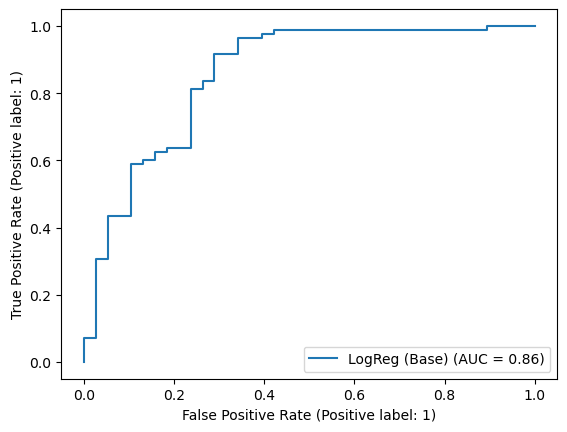

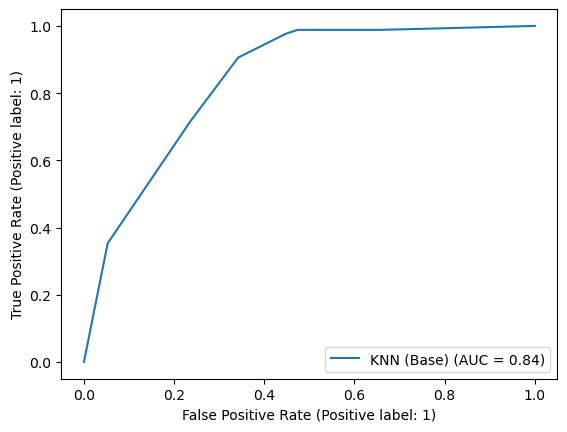

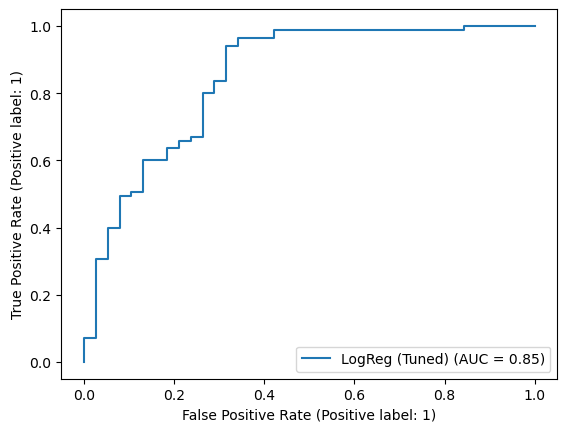

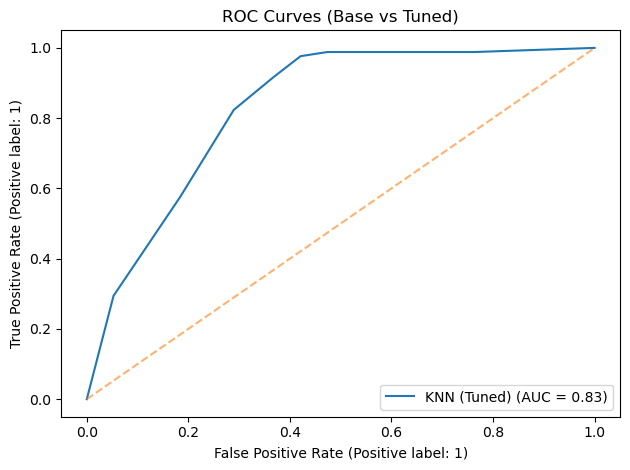

In [15]:
# Reuse the helper from earlier: evaluate_classifier(name, model, X_test, y_test)

res3, proba3 = evaluate_classifier("LogReg (Tuned)", logreg_best, X_test, y_test)
res4, proba4 = evaluate_classifier("KNN (Tuned)", knn_best, X_test, y_test)

# Combine with previous results (results_df existed earlier)
results_df = pd.concat([results_df, pd.DataFrame([res3, res4])], ignore_index=True)
display(results_df.sort_values('ROC_AUC', ascending=False))

# Plot both tuned ROC curves alongside originals
plt.figure()
RocCurveDisplay.from_predictions(y_test, proba1, name='LogReg (Base)')
RocCurveDisplay.from_predictions(y_test, proba2, name='KNN (Base)')
RocCurveDisplay.from_predictions(y_test, proba3, name='LogReg (Tuned)')
RocCurveDisplay.from_predictions(y_test, proba4, name='KNN (Tuned)')
plt.plot([0,1], [0,1], '--', alpha=0.6)
plt.title('ROC Curves (Base vs Tuned)')
plt.tight_layout()
plt.show()

## Add a Simple Baseline (DummyClassifier)
This predicts the **most frequent class** and gives us a baseline to beat.

In [16]:
from sklearn.dummy import DummyClassifier

dummy_pipe = Pipeline(steps=[
    ('preprocess', preprocess),  # harmless; keeps interface consistent
    ('select', fs_selector),
    ('model', DummyClassifier(strategy='most_frequent'))
])

dummy_pipe.fit(X_train, y_train)
res_dummy, proba_dummy = evaluate_classifier("Dummy (Most Frequent)", dummy_pipe, X_test, y_test)

results_df = pd.concat([results_df, pd.DataFrame([res_dummy])], ignore_index=True)
display(results_df.sort_values('ROC_AUC', ascending=False))


=== Dummy (Most Frequent) ===
Accuracy : 0.691
Precision: 0.691
Recall   : 1.000
F1-score : 0.817
ROC AUC  : 0.500

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        38
           1      0.691     1.000     0.817        85

    accuracy                          0.691       123
   macro avg      0.346     0.500     0.409       123
weighted avg      0.478     0.691     0.565       123



,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.845528,0.858696,0.929412,0.892655,0.855418
2,LogReg (Tuned),0.861789,0.840000,0.988235,0.908108,0.847988
1,KNN (k=7),0.845528,0.830000,0.976471,0.897297,0.840402
3,KNN (Tuned),0.853659,0.838384,0.976471,0.902174,0.830495
4,Dummy (Most Frequent),0.691057,0.691057,1.000000,0.817308,0.500000


## Metrics Bar Charts (Side-by-Side)
Visual comparison across models for **Accuracy**, **F1**, and **ROC AUC**.

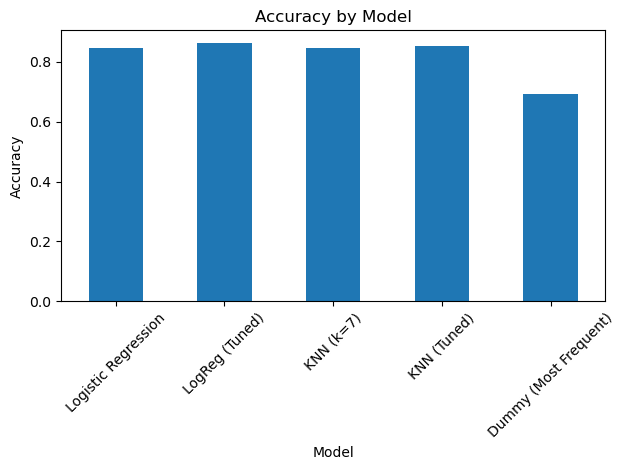

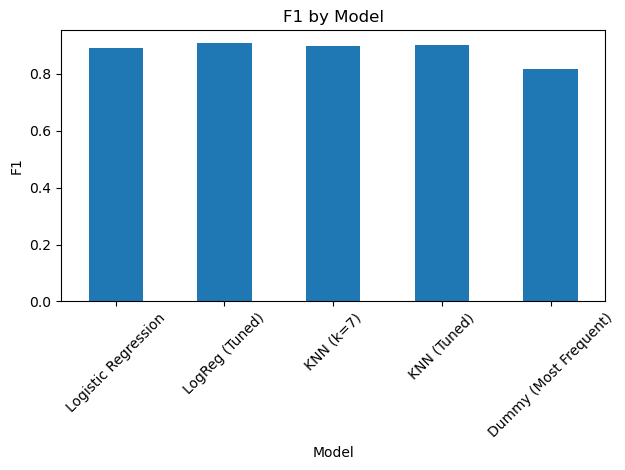

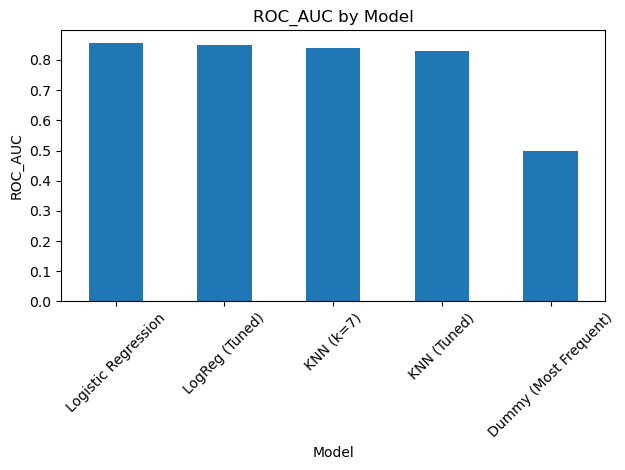

In [17]:
metrics_to_plot = ['Accuracy', 'F1', 'ROC_AUC']

# Sort by ROC_AUC for nicer ordering
plot_df = results_df.copy().sort_values('ROC_AUC', ascending=False)

for metric in metrics_to_plot:
    ax = plot_df.plot(kind='bar', x='Model', y=metric, legend=False, rot=45)
    ax.set_title(f'{metric} by Model')
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    plt.tight_layout()
    plt.show()

### Why Didn’t the Tuned Models Perform Better?

When we applied hyperparameter tuning (GridSearchCV), the results of the tuned models were **not better than the base models**. This is a common situation, and here are the possible reasons:

---

### 1. Dataset is Small
- The Loan Approval dataset only has a few hundred rows.  
- With small datasets, results can fluctuate.  
- Scikit-learn’s default parameters are often already good enough for small problems.

---

### 2. Model Complexity vs. Data Size
- **Logistic Regression**: tuning `C` only changes regularization strength. With few samples, the decision boundary doesn’t move much.  
- **KNN**: highly sensitive to dataset size. With few samples, changing `k` can cause overfitting or underfitting without improving test results.

---

### 3. Cross-Validation Variance
- GridSearchCV uses **cross-validation**.  
- With small data, each fold is tiny, so results are noisy.  
- The “best” hyperparameters may not generalize well to the final test set.

---

### 4. Class Imbalance
- Approvals (class 1) are more common than rejections (class 0).  
- Metrics like Accuracy or ROC AUC can look strong even if the model isn’t improving on the minority class.  
- Tuning alone doesn’t fix imbalance — we may need resampling or class-weight adjustments.

---

### 5. Overfitting to Validation Folds
- GridSearchCV may **overfit to the CV folds**.  
- On the **held-out test set**, tuned parameters may not perform better (sometimes worse).

---

## Summary
- Logistic Regression was already strong (ROC AUC ≈ 0.855), leaving little room for improvement.  
- KNN already overfit approvals (very high recall) but struggled with rejections.  
- Hyperparameter tuning cannot fully fix these limitations.

---

